# ex2.1 jack's car rental solving

## See p. 81 (section 4.3, example 4.2) in Sutton's Reinforcement learning: An introduction

Goal:

- implementing value iteration in dynamic programming

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## copy the code from ex2.0 here

Note: numba's jit could compile python's code to near native performance. If you can use it without problems, good for you, if not, just remove the line `@jit(nopython=True)`.

In [0]:
import numpy as np
from scipy.stats import poisson
from numba import jit

N_CARS = 20

# renting and returning propabilities
P_RETURN_A = poisson.pmf(np.arange(0, N_CARS + 1), 3)
P_RENT_A = poisson.pmf(np.arange(0, N_CARS + 1), 3)
P_RETURN_B = poisson.pmf(np.arange(0, N_CARS + 1), 2)
P_RENT_B = poisson.pmf(np.arange(0, N_CARS + 1), 4)

# @jit(nopython=True)
def step_rent(n_car, p):
    # code here ...
    # ...
    pp = [0] * len(p)
    r = 0
    for i in range(len(p)):
        if(i <= n_car):
            pp[n_car-i] = p[i]
            r += p[i] * i * 10
        else:
            pp[0] += p[i]
            r += p[i] * n_car * 10
    return pp, r

# @jit(nopython=True)
def step_return(p_car, p):
    # code here ...
    # ...
    pp = [0] * len(p)
    for present_car in range(len(p_car)):
        for return_car in range(len(p)):
            if(present_car + return_car <= N_CARS):
                pp[present_car + return_car] += p_car[present_car] * p[return_car]
            else:
                pp[N_CARS] += p_car[present_car] * p[return_car]
    
    return pp

def step_rent_return(n_car, p_rent, p_return):
    p, r = step_rent(n_car, p_rent)
    p = step_return(p, p_return)
    return p, r

def step_env(s, a):
    """step a on state s, returning the next state distribution and the expected reward"""
    # s = (N_CARS_IN_A, N_CARS_IN_B)
    # move cars
    # code here ...
    # ...
    move_cost = 2
    m_s = (min(N_CARS, s[0] - a), min(N_CARS, s[1] + a))
    # renting and returning
    # code here ...
    # ...
    p_A, r_A = step_rent_return(m_s[0], P_RENT_A, P_RETURN_A)
    p_B, r_B = step_rent_return(m_s[1], P_RENT_B, P_RETURN_B)
    # p is the "joint" probability over cars at first and second location
    # p has the shape of [N_CARS+1, N_CARS+1] where the dim=0 is the first location, dim=1 is the second location
    # r is the expected reward
    p = np.zeros(shape=(len(p_A), len(p_B)), dtype=np.float)
    for i in range(len(p_A)):
        for j in range(len(p_B)):
            p[i][j] = p_A[i] * p_B[j]
    r = r_A + r_B - abs(a) * move_cost
    return p, r

# value iteration

implement the value iteration to solve this Jack's car rental problem.

In [0]:
def value_itr(v, thresh=1e-4):
    """implement the value iteration algorithm"""
    # v = value table, has a shape of [N_CARS+1, N_CARS+1]
    # make change to the v in-place
    # code here ...
    gamma = 0.9
    MAX_CARS_MOVE = 5
    actions = sorted([-a for a in range(1,MAX_CARS_MOVE+1)] + [a for a in range(MAX_CARS_MOVE+1)])
    delta = 1
    steps = 0
    while(delta >= thresh):
        delta = 0
        for c_A in range(v.shape[0]):
            for c_B in range(v.shape[1]):
                best_a = 0
                best_v = 0
                # take some actions                
                for a in actions:
                    if((c_A - a < 0) or (c_B + a < 0)):
                        continue
                    p, r = step_env((c_A, c_B), a)
                    c_v = 0
                    # Expectation Value of current state (c_A, c_B) taking action a
                    # Expectation over all next state (n_A, n_B) 
                    for n_A in range(p.shape[0]):
                        for n_B in range(p.shape[1]):
                            c_v += p[n_A][n_B] * (r + (gamma * v[n_A][n_B]))

                    if(c_v > best_v):
                        best_a = a
                        best_v = c_v
                            
                delta = max(delta, abs(v[c_A][c_B] - best_v))
                v[c_A][c_B] = best_v
        steps += 1
        print(steps, delta, v.min(), v.max())
                
    return v       

## verify the solution value

1 295.6037703491091 0.0 295.6037703491091
2 111.51738876034632 51.908238485032115 388.20215068165925
3 88.00042475615192 110.66412860536904 448.8957022095305
4 66.24877997120711 164.1405563811355 493.29613357102494
5 49.97781631394054 209.6868496948452 525.8662361053847
6 38.544967370521476 247.6274011811052 549.8290272215282
7 31.327380220579073 278.9547814016843 567.7561538857337
8 25.758029410224424 304.7128108119087 581.4412585082607
9 21.132826574137994 325.8456373860467 592.085611525911
10 17.318295906180822 343.1639332922275 600.4941445624714
11 14.183182807905837 357.34711610013335 607.2169538061057
12 11.612985479413908 368.96010157954726 612.6406162739884
13 9.507900320752185 378.46800190029944 617.0451376050285
14 7.783924588564446 386.2519264888639 620.6386151948343
15 6.37248856663723 392.6244150555011 623.5782873962385
16 5.217161134029993 397.8415761895311 625.9878447844303
17 4.271343154126441 402.11291934365755 627.9639735013892
18 3.4970452886363432 405.6099646322939 

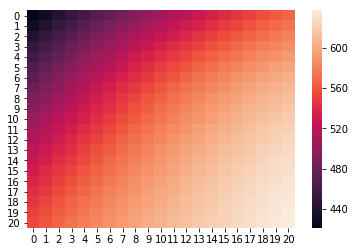

In [0]:
%%time
v = np.zeros((N_CARS+1, N_CARS+1))
value_itr(v)
print(v.min(), v.max())
sns.heatmap(v)

Expected result:

421.4136554821914 636.9894057704319

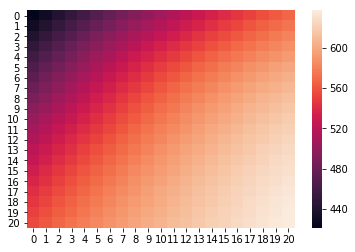

# show the greedy policy

In [0]:
def greedy(v):
    """return the greedy policy wrt. a given value table"""
    pi = np.zeros((N_CARS+1, N_CARS+1))
    # code here ...
    # ...
    gamma = 0.9
    for c_A in range(v.shape[0]):
        for c_B in range(v.shape[1]):
            # take some actions                
            best_v = 0
            for a in actions:
                if((c_A - a < 0) or (c_B + a < 0)):
                    continue
                p, r = step_env((c_A, c_B), a)
                c_v = 0
                # Expectation Value of current state (c_A, c_B) taking action a
                # Expectation over all next state (n_A, n_B) 
                for n_A in range(p.shape[0]):
                    for n_B in range(p.shape[1]):
                        c_v += p[n_A][n_B] * (r + (gamma * v[n_A][n_B]))

                if(c_v > best_v):
                    best_a = a
                    best_v = c_v
                            
            pi[c_A][c_B] = best_a

    return pi

## verify the greedy solution policy

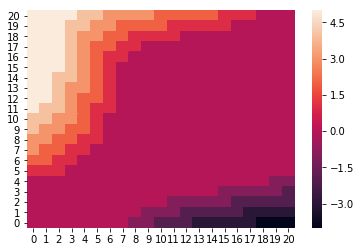

In [0]:
pi = greedy(v)
sns.heatmap(pi[::-1], xticklabels=range(N_CARS+1), yticklabels=list(reversed(range(N_CARS+1))))

Expected result:

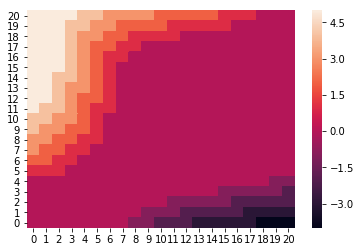

# If we change the renting and returning probabilities like the following:

In [0]:
P_RETURN_A = poisson.pmf(np.arange(0, N_CARS + 1), 0)
P_RENT_A = poisson.pmf(np.arange(0, N_CARS + 1), 4)
P_RETURN_B = poisson.pmf(np.arange(0, N_CARS + 1), 4)
P_RENT_B = poisson.pmf(np.arange(0, N_CARS + 1), 0)

## Q: what is an expected behavior?

An agent should try to move cars into station A. It still get some rewards even if customers will not return any cars back. Cars at station B will not generate any reward because the probability of renting at station B is 0.